# Análise de Qualidade do Ar - Beijing Changping (2016)

## Relatório de Modelagem Estatística

**Autor:** Yago Schnorr e Gabriel Miranda  
**Instituição:** CESUPA - Centro Universitário do Estado do Pará  
**Disciplina:** Modelagem Estatística - CC4  
**Data:** Dezembro de 2025

---

## 1. Introdução e Objetivos

### 1.1 Contexto

A poluição atmosférica representa um dos principais desafios ambientais e de saúde pública global, especialmente em grandes centros urbanos. A China, em particular, tem enfrentado sérios problemas relacionados à qualidade do ar, com destaque para as altas concentrações de material particulado (PM2.5 e PM10) que afetam milhões de pessoas.

O monitoramento contínuo da qualidade do ar e a capacidade de prever níveis de poluição são fundamentais para:
- Implementação de políticas públicas de controle ambiental
- Alertas preventivos à população
- Planejamento urbano e industrial
- Proteção da saúde pública

### 1.2 Objetivos do Projeto

Este projeto tem como objetivo aplicar técnicas de aprendizado de máquina para:

**Objetivo Principal:**
- Desenvolver modelos para verificar relações entre variáveis no dataset 
- Verificar o efeito das condições meteorológicas no ar

**Objetivos Específicos:**
1. Realizar análise exploratória completa dos dados de qualidade do ar
2. Implementar e comparar modelos de regressão (Linear Simples, Múltipla e Polinomial)
3. Implementar e comparar modelos de classificação (Naive Bayes e Regressão Logística) 
4. Avaliar o desempenho dos modelos utilizando métricas apropriadas
5. Otimizar os modelos através de técnicas de validação e tuning de hiperparâmetros
6. Identificar os principais fatores que influenciam a qualidade do ar

### 1.3 Hipóteses de Negócio

- **H1:** Existe correlação significativa entre diferentes poluentes atmosféricos (PM10, SO2, NO2, CO, O3) e os níveis de PM2.5
- **H2:** Variáveis meteorológicas (temperatura, pressão, umidade, velocidade do vento) influenciam significativamente a dispersão de poluentes

---

## 2. Descrição dos Dados e Licença

### 2.1 Fonte dos Dados

**Dataset:** PRSA Data - PM2.5 of Five Chinese Cities  
**Fonte:** UCI Machine Learning Repository  
**URL:** https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data  
**Período:** 01/03/2013 a 28/02/2017  
**Estação de Monitoramento:** Changping, Beijing, China  

### 2.2 Licença

Os dados são disponibilizados publicamente para fins acadêmicos e de pesquisa. Este projeto utiliza os dados em conformidade com as políticas do UCI Machine Learning Repository.

**Citação:**
> Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. Proceedings of the Royal Society A, Volume 473, No. 2205, Pages 20170457.

### 2.3 Descrição das Variáveis

O dataset contém dados horários de qualidade do ar e meteorológicos:

**Variáveis Temporais:**
- `year`, `month`, `day`, `hour`: Data e hora da medição
- `No`: Identificador da linha

**Variáveis de Poluentes (µg/m³):**
- `PM2.5`: Concentração de partículas finas (< 2.5 µm) - **Variável alvo para regressão**
- `PM10`: Concentração de partículas inaláveis (< 10 µm)
- `SO2`: Dióxido de enxofre
- `NO2`: Dióxido de nitrogênio
- `CO`: Monóxido de carbono
- `O3`: Ozônio

**Variáveis Meteorológicas:**
- `TEMP`: Temperatura (°C)
- `PRES`: Pressão atmosférica (hPa)
- `DEWP`: Ponto de orvalho (°C)
- `RAIN`: Precipitação (mm)
- `wd`: Direção do vento (categórica)
- `WSPM`: Velocidade do vento (m/s)

**Variáveis Derivadas (criadas neste projeto):**
- `AQI`: Índice de Qualidade do Ar (calculado segundo padrão chinês HJ 633-2012)
- `Quality`: Classificação categórica da qualidade do ar - **Variável alvo para classificação**

### 2.4 Escopo da Análise

Para este projeto, **focamos exclusivamente nos dados de 2016**, garantindo:
- Dados mais recentes e representativos
- Conjunto de dados manejável para análise
- Período completo de 12 meses com sazonalidade

---

## 3. Importação de Bibliotecas

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, label_binarize, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from scipy.stats import loguniform
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 4. Carregamento e Preparação dos Dados

### 4.1 Carregamento do Dataset

In [65]:
df = pd.read_csv('data/PRSA_Data_Changping_20130301-20170228.csv')

In [66]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping


### 4.2 Inspeção Inicial dos Dados

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34290 non-null  float64
 6   PM10     34482 non-null  float64
 7   SO2      34436 non-null  float64
 8   NO2      34397 non-null  float64
 9   CO       33543 non-null  float64
 10  O3       34460 non-null  float64
 11  TEMP     35011 non-null  float64
 12  PRES     35014 non-null  float64
 13  DEWP     35011 non-null  float64
 14  RAIN     35013 non-null  float64
 15  wd       34924 non-null  object 
 16  WSPM     35021 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


### 4.3 Filtragem dos Dados - Ano 2016

Para garantir consistência e foco na análise, filtramos apenas os dados do ano de 2016:

In [68]:
df_2016 = df[df['year'] == 2016]

In [69]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 24864 to 33647
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       8784 non-null   int64  
 1   year     8784 non-null   int64  
 2   month    8784 non-null   int64  
 3   day      8784 non-null   int64  
 4   hour     8784 non-null   int64  
 5   PM2.5    8670 non-null   float64
 6   PM10     8688 non-null   float64
 7   SO2      8652 non-null   float64
 8   NO2      8670 non-null   float64
 9   CO       8650 non-null   float64
 10  O3       8685 non-null   float64
 11  TEMP     8777 non-null   float64
 12  PRES     8777 non-null   float64
 13  DEWP     8777 non-null   float64
 14  RAIN     8777 non-null   float64
 15  wd       8741 non-null   object 
 16  WSPM     8779 non-null   float64
 17  station  8784 non-null   object 
dtypes: float64(11), int64(5), object(2)
memory usage: 1.3+ MB


### 4.4 Tratamento de Valores Ausentes

#### 4.4.1 Identificação de Valores Nulos

In [70]:
df_2016.isnull().sum()

No           0
year         0
month        0
day          0
hour         0
PM2.5      114
PM10        96
SO2        132
NO2        114
CO         134
O3          99
TEMP         7
PRES         7
DEWP         7
RAIN         7
wd          43
WSPM         5
station      0
dtype: int64

#### 4.4.2 Estratégia de Tratamento

**Decisão:** Remoção de linhas com valores ausentes

**Justificativa:**
- Inicialmente, consideramos usar o modelo de regressão linear para imputar valores de PM2.5 faltantes
- Após análise, verificamos que poucos registros permaneceriam com PM2.5 nulo após exclusão dos nulos das variáveis independentes
- Optamos por excluir todas as linhas com valores ausentes para garantir integridade dos dados
- Esta abordagem é adequada pois ainda mantemos um volume substancial de dados para modelagem

In [71]:
df_2016 = df_2016.dropna(subset=['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM'])

In [72]:
df_2016.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
PM2.5      12
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd          0
WSPM        0
station     0
dtype: int64

In [73]:
df_2016 = df_2016.dropna(subset=['PM2.5'])

### 4.5 Estatísticas Descritivas

In [74]:
df_2016.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,8459.000000,8459.0,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000,8459.000000
mean,29237.323797,2016.0,6.488237,15.735784,11.462230,60.837451,85.564015,8.117626,45.568270,1121.941128,53.836624,13.400505,1007.930287,1.602494,0.066344,1.983237
std,2540.846591,0.0,3.458014,8.786884,6.943057,62.588812,75.334613,9.723610,29.409679,1027.588676,52.197327,11.774260,10.359994,14.279198,0.663958,1.329337
min,24865.000000,2016.0,1.000000,1.000000,0.000000,3.000000,3.000000,2.000000,2.000000,100.000000,2.000000,-16.600000,985.400000,-35.100000,0.000000,0.100000
25%,27031.500000,2016.0,3.000000,8.000000,5.000000,15.000000,31.000000,2.000000,24.000000,500.000000,13.000000,2.900000,999.200000,-10.800000,0.000000,1.100000
50%,29226.000000,2016.0,6.000000,16.000000,11.000000,40.000000,65.000000,4.000000,37.000000,800.000000,44.000000,14.375000,1007.200000,2.700000,0.000000,1.600000
75%,31450.500000,2016.0,10.000000,23.000000,18.000000,85.000000,118.000000,10.000000,61.000000,1300.000000,71.000000,23.400000,1016.100000,14.100000,0.000000,2.400000
max,33648.000000,2016.0,12.000000,31.000000,23.000000,492.000000,933.000000,119.000000,208.000000,10000.000000,327.000000,38.100000,1036.500000,26.900000,22.700000,9.400000


### 4.6 Criação de Variáveis Derivadas

#### 4.6.1 Cálculo do Índice de Qualidade do Ar (AQI)

Implementamos o cálculo do AQI seguindo o padrão chinês (HJ 633-2012), que considera:
- 6 poluentes principais: PM2.5, PM10, SO2, NO2, CO, O3
- Breakpoints específicos para cada poluente
- O AQI final é o maior valor entre todos os poluentes (poluente dominante)

In [75]:
def calculate_aqi_china(concentration, pollutant):
    if pollutant == 'CO':
        concentration = concentration / 1000
    
    # Breakpoints da escala chinesa (HJ 633-2012)
    breakpoints = {
        'PM2.5': [
            (0, 35, 0, 50),
            (35, 75, 50, 100),
            (75, 115, 100, 150),
            (115, 150, 150, 200),
            (150, 250, 200, 300),
            (250, 350, 300, 400),
            (350, 500, 400, 500)
        ],
        'PM10': [
            (0, 50, 0, 50),
            (50, 150, 50, 100),
            (150, 250, 100, 150),
            (250, 350, 150, 200),
            (350, 420, 200, 300),
            (420, 500, 300, 400),
            (500, 600, 400, 500)
        ],
        'SO2': [
            (0, 50, 0, 50),
            (50, 150, 50, 100),
            (150, 475, 100, 150),
            (475, 800, 150, 200),
            (800, 1600, 200, 300),
            (1600, 2100, 300, 400),
            (2100, 2620, 400, 500)
        ],
        'NO2': [
            (0, 40, 0, 50),
            (40, 80, 50, 100),
            (80, 180, 100, 150),
            (180, 280, 150, 200),
            (280, 565, 200, 300),
            (565, 750, 300, 400),
            (750, 940, 400, 500)
        ],
        'CO': [
            (0, 2, 0, 50),
            (2, 4, 50, 100),
            (4, 14, 100, 150),
            (14, 24, 150, 200),
            (24, 36, 200, 300),
            (36, 48, 300, 400),
            (48, 60, 400, 500)
        ],
        'O3': [
            (0, 160, 0, 50),
            (160, 200, 50, 100),
            (200, 300, 100, 150),
            (300, 400, 150, 200),
            (400, 800, 200, 300),
            (800, 1000, 300, 400),
            (1000, 1200, 400, 500)
        ]
    }
    
    if pollutant not in breakpoints:
        raise ValueError(f"Poluente '{pollutant}' não suportado")
    
    for C_Lo, C_Hi, IAQI_Lo, IAQI_Hi in breakpoints[pollutant]:
        if C_Lo <= concentration <= C_Hi:
            # Fórmula para encontrar o AQI
            IAQI = ((IAQI_Hi - IAQI_Lo) / (C_Hi - C_Lo)) * (concentration - C_Lo) + IAQI_Lo
            return round(IAQI)
    
    return 500

def calculate_aqi_row(row):
    aqi_values = []
    
    if pd.notna(row['PM2.5']):
        aqi_values.append(calculate_aqi_china(row['PM2.5'], 'PM2.5'))
    if pd.notna(row['PM10']):
        aqi_values.append(calculate_aqi_china(row['PM10'], 'PM10'))
    if pd.notna(row['SO2']):
        aqi_values.append(calculate_aqi_china(row['SO2'], 'SO2'))
    if pd.notna(row['NO2']):
        aqi_values.append(calculate_aqi_china(row['NO2'], 'NO2'))
    if pd.notna(row['CO']):
        aqi_values.append(calculate_aqi_china(row['CO'], 'CO'))
    if pd.notna(row['O3']):
        aqi_values.append(calculate_aqi_china(row['O3'], 'O3'))
    
    return max(aqi_values) if aqi_values else np.nan

df_2016['AQI'] = df_2016.apply(calculate_aqi_row, axis=1)

#### 4.6.2 Classificação da Qualidade do Ar

Com base no AQI calculado, criamos categorias de qualidade do ar:

| Faixa AQI | Categoria | Descrição |
|-----------|-----------|-----------|
| 0-50 | Bom | Qualidade do ar satisfatória, sem risco |
| 51-100 | Moderado | Aceitável, pode haver risco para grupos sensíveis |
| 101-150 | Levemente Poluído | Grupos sensíveis podem sentir efeitos |
| 151-200 | Moderadamente Poluído | População em geral pode sentir efeitos |
| 201-300 | Fortemente Poluído | Alerta de saúde, população afetada |
| 300+ | Perigoso | Emergência de saúde, toda população em risco |

In [76]:
def classify_air_quality(aqi):
    if pd.isna(aqi):
        return np.nan
    elif aqi <= 50:
        return 'Bom'
    elif aqi <= 100:
        return 'Moderado'
    elif aqi <= 150:
        return 'Levemente Poluido'
    elif aqi <= 200:
        return 'Moderadamente Poluido'
    elif aqi <= 300:
        return 'Fortemente Poluido'
    else:
        return 'Perigoso'

df_2016['Quality'] = df_2016['AQI'].apply(classify_air_quality)

df_2016['Quality'].value_counts(ascending=False)

Quality
Moderado                 3009
Bom                      2657
Levemente Poluido        1450
Fortemente Poluido        622
Moderadamente Poluido     549
Perigoso                  172
Name: count, dtype: int64

---

## 5. Análise Exploratória de Dados (EDA)

A análise exploratória é fundamental para compreender as características dos dados, identificar padrões, relações entre variáveis e orientar as decisões de modelagem.

### 5.1 Mapa de Calor - Correlação entre Variáveis

O mapa de calor permite visualizar as correlações entre todas as variáveis numéricas, identificando relações lineares fortes e possíveis problemas de multicolinearidade.

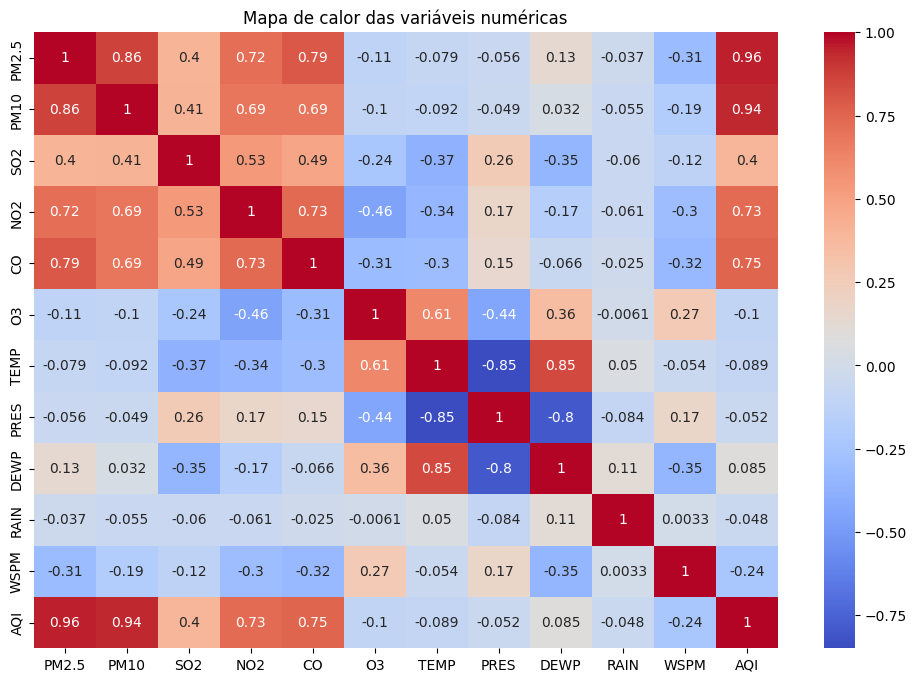

In [77]:
df_2016_num = df_2016.select_dtypes(include=['number']).drop(columns=['year', 'month', 'day', 'hour', 'No'])

plt.subplots(figsize=(12,8))
sns.heatmap(df_2016_num.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor das variáveis numéricas')
plt.show()

**Principais Observações do Mapa de Calor:**
- **PM2.5 e PM10** apresentam forte correlação positiva (>0.8), esperado pois ambos são materiais particulados
- **CO, NO2, SO2** também mostram correlação positiva com PM2.5, indicando fontes comuns de poluição
- **O3 (Ozônio)** apresenta correlação negativa com outros poluentes, comportamento típico em áreas urbanas
- **TEMP e DEWP** possuem alta correlação entre si
- **PRES (pressão)** mostra correlação negativa com temperatura

### 5.2 Análise de Distribuições - Histogramas

Os histogramas revelam a distribuição de cada variável, permitindo identificar assimetrias, valores extremos e padrões de comportamento.

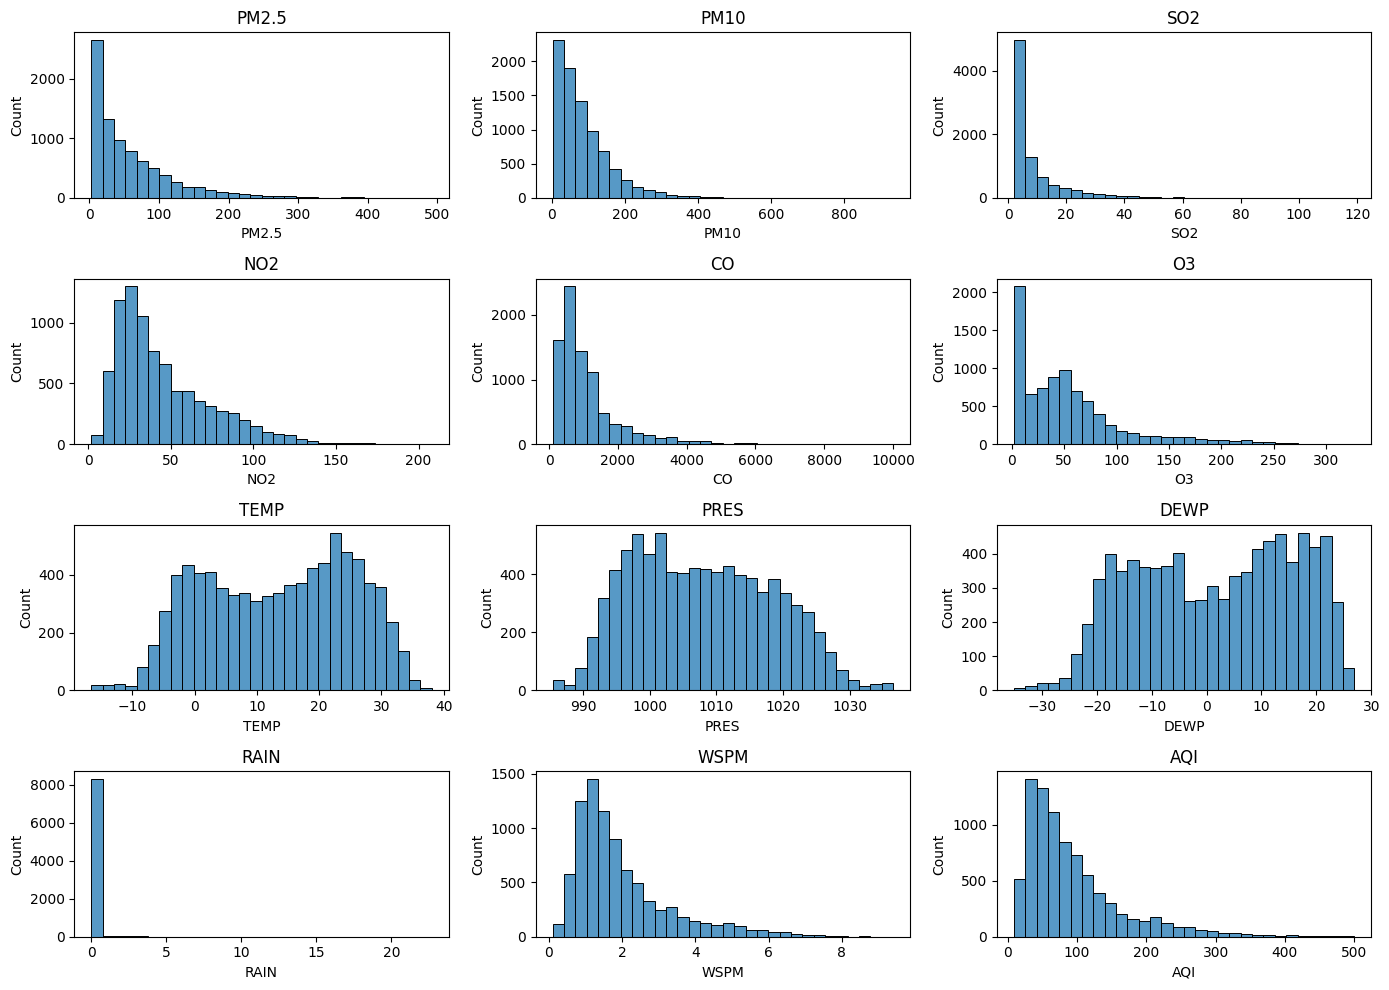

In [78]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,10))
ax = ax.flatten()

cols = df_2016_num.columns

for i, col in enumerate(cols):
    sns.histplot(df_2016_num[col], bins=30, kde=False, ax=ax[i])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

**Insights dos Histogramas:**
- **PM2.5 e PM10**: Distribuições assimétricas positivas, com concentração em valores baixos e cauda longa
- **Poluentes gasosos (SO2, NO2, CO, O3)**: Também apresentam assimetria positiva
- **Variáveis meteorológicas**: TEMP e DEWP mostram distribuições mais próximas da normal
- **PRES**: Distribuição aproximadamente normal
- A assimetria sugere que transformações logarítmicas podem melhorar a modelagem

### 5.3 Análise de Relações - Gráficos de Dispersão

Os scatter plots permitem visualizar relações entre cada variável independente e nossa variável alvo (PM2.5).

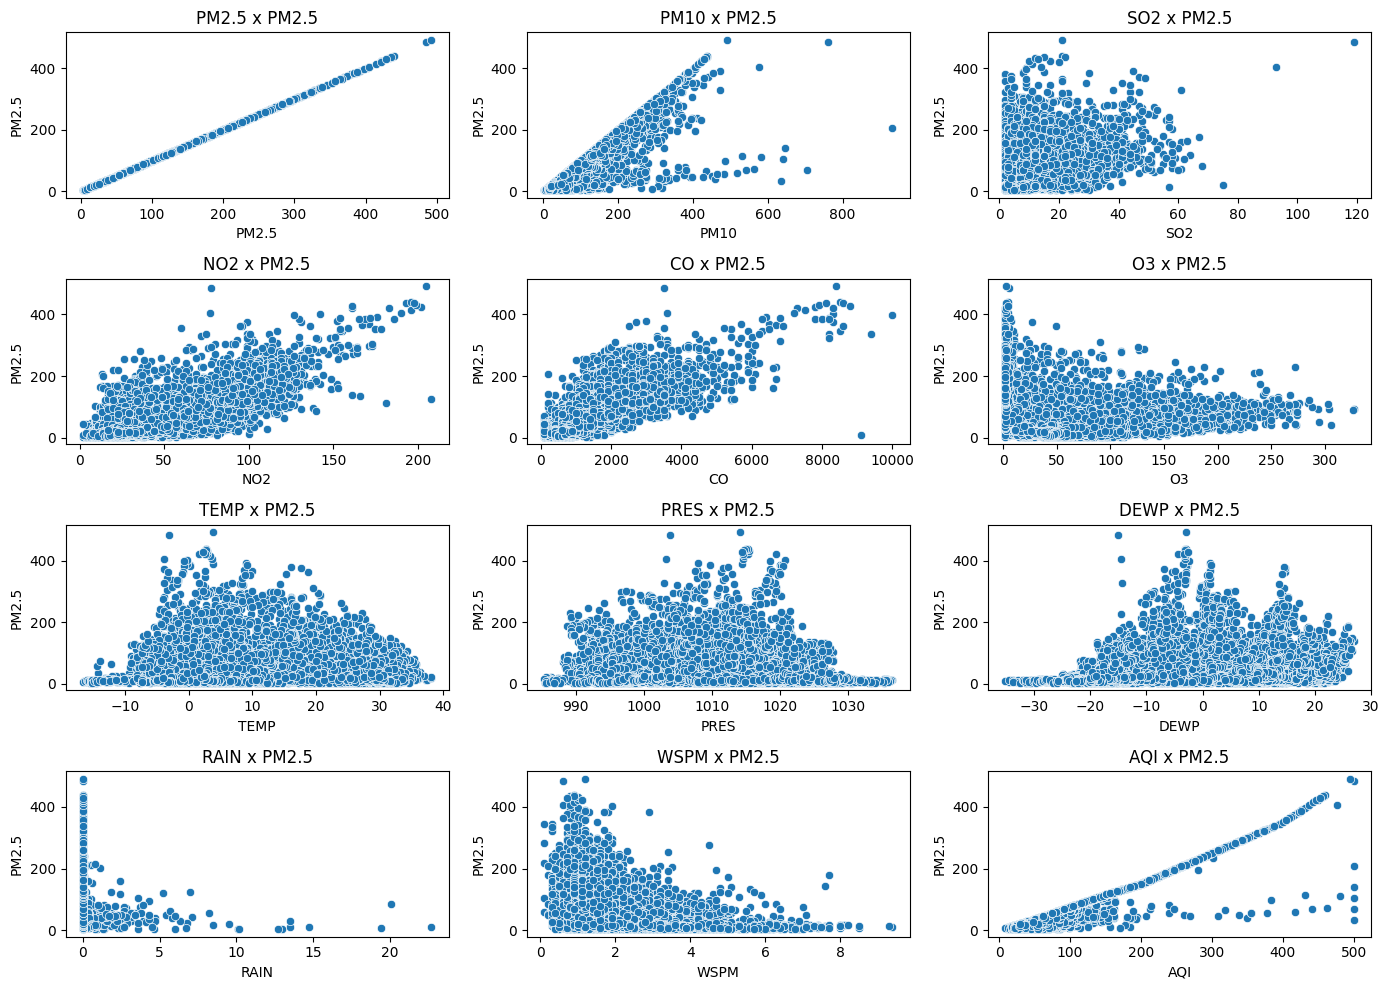

In [79]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,10))
ax = ax.flatten()

cols = df_2016_num.columns

for i, col in enumerate(cols):
    sns.scatterplot(x=df_2016_num[col], y=df_2016_num['PM2.5'], ax=ax[i])
    ax[i].set_title(f'{col} x PM2.5')

plt.tight_layout()
plt.show()

**Análise das Relações com PM2.5:**
- **PM10**: Relação linear positiva forte e clara
- **SO2, NO2, CO**: Relações positivas, mas com maior dispersão
- **O3**: Relação negativa/inversa
- **TEMP**: Relação não-linear, possivelmente quadrática
- **WSPM**: Relação negativa (maior velocidade do vento dispersa poluentes)

### 5.4 Detecção de Outliers - Boxplots

Os boxplots permitem identificar valores atípicos e avaliar a dispersão das variáveis.

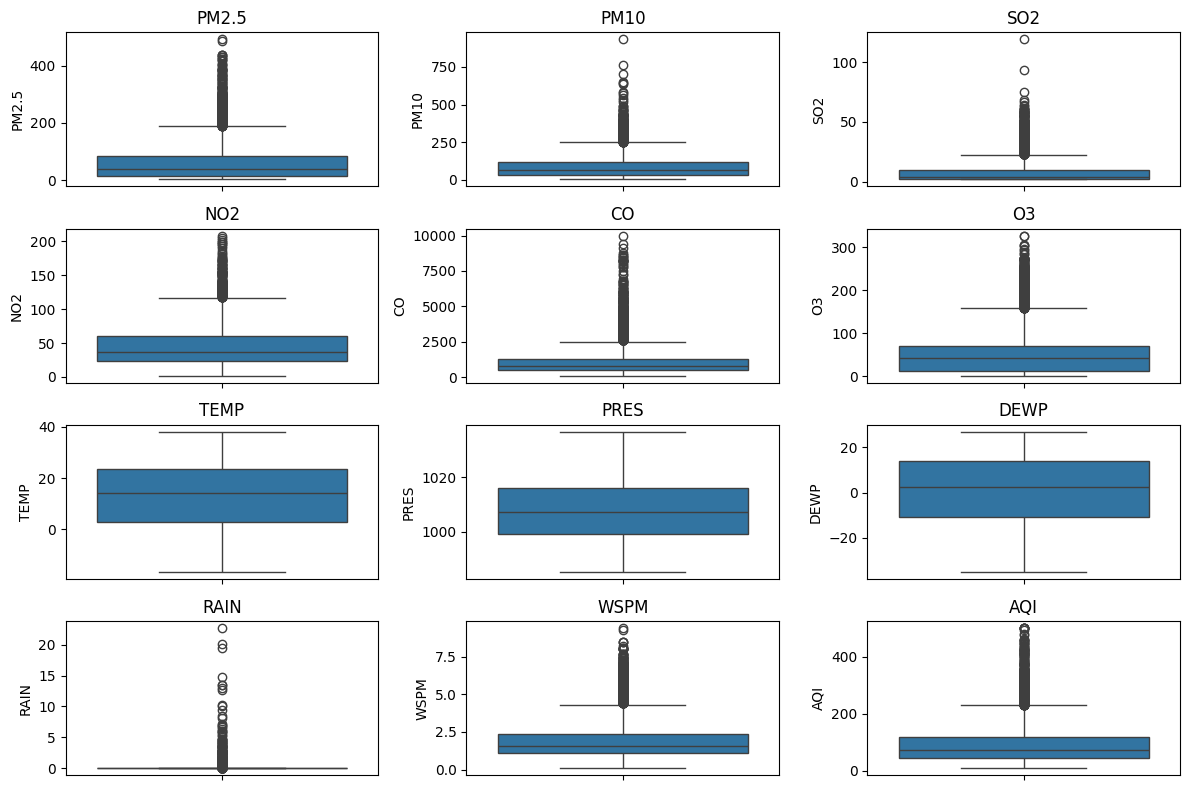

In [80]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,8))
ax = ax.flatten()

cols = df_2016_num.columns

for i, col in enumerate(cols):
    sns.boxplot(df_2016_num[col], ax=ax[i])
    ax[i].set_title(col)


plt.tight_layout()
plt.show()

**Observações sobre Outliers:**
- **PM2.5, PM10, CO, NO2, SO2**: Presença significativa de outliers superiores
- Estes outliers representam **episódios reais de alta poluição** e não devem ser removidos
- São eventos importantes para o modelo capturar condições extremas
- **Decisão**: Manter os outliers por representarem condições reais de interesse

### 5.5 Transformação de Variáveis

#### 5.5.1 Conversão da Variável RAIN para Booleana

Analisando a distribuição da variável precipitação:

In [81]:
df_2016['RAIN'].value_counts()

RAIN
0.0    8108
0.1      70
0.2      34
0.3      31
0.5      18
       ... 
5.2       1
2.0       1
6.3       1
3.8       1
5.7       1
Name: count, Length: 64, dtype: int64

In [82]:
df_2016['RAIN'] = (df_2016['RAIN'] > 0).astype(int)

In [83]:
df_2016['RAIN'].value_counts()

RAIN
0    8108
1     351
Name: count, dtype: int64

**Justificativa da Transformação:**
- A variável RAIN possui maioria de valores zero (sem chuva)
- Quando há chuva, a quantidade específica varia pouco em termos de impacto na qualidade do ar
- Simplificamos para binária: 0 (sem chuva) ou 1 (com chuva)
- Esta transformação facilita a interpretação e reduz ruído

---

## 6. Modelagem

### 6.1 Definição do Problema e Estratégia

**Problema de Regressão:**
- **Variável Alvo**: PM2.5 (concentração de material particulado fino)
- **Features**: PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WSPM

**Problema de Classificação:**
- **Variável Alvo**: Quality (categoria de qualidade do ar)
- **Features**: Mesmas variáveis independentes

**Divisão dos Dados:**
- **Treino**: 60% dos dados
- **Validação**: 20% dos dados
- **Teste**: 20% dos dados
- **Random State**: 42 (reprodutibilidade)

### 6.2 Estabelecimento de Baseline

Antes de construir modelos complexos, estabelecemos um baseline simples para comparação:

In [84]:
features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

X = df_2016[features]
y = df_2016['PM2.5']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

baseline_pred = np.full_like(y_val, y_train.mean())

print(f'R2 Baseline: {r2_score(y_val, baseline_pred)}')
print(f'MAE Baseline {mean_absolute_error(y_val, baseline_pred)}')
print(f'RMSE Baseline: {root_mean_squared_error(y_val, baseline_pred)}')

R2 Baseline: -0.0005021869978609761
MAE Baseline 46.00490980446959
RMSE Baseline: 62.6423358238305


**Resultados do Baseline (Regressão):**
- Baseline: predição constante usando a média do treino
- Estabelece o mínimo que qualquer modelo deve superar

### 6.3 Regressão Linear Simples

Iniciamos com o modelo mais simples: regressão linear usando apenas PM10 como preditor, dado que apresentou a correlação mais forte com PM2.5.

In [85]:
X_train_simple = X_train[['PM10']]
X_val_simple = X_val[['PM10']]

simple_linear_regression = LinearRegression()
simple_linear_regression.fit(X_train_simple, y_train)

y_pred_simple = simple_linear_regression.predict(X_val_simple)

print(f'R2 Regressão Linear Simples: {r2_score(y_val, y_pred_simple)}')
print(f'MAE Regressão Linear Simples: {mean_absolute_error(y_val, y_pred_simple)}')
print(f'RMSE Regressão Linear Simples: {root_mean_squared_error(y_val, y_pred_simple)}')

R2 Regressão Linear Simples: 0.778207209393911
MAE Regressão Linear Simples: 17.605481403452924
RMSE Regressão Linear Simples: 29.49392930375542


**Análise do Modelo Simples:**
- Já supera significativamente o baseline
- PM10 sozinho explica grande parte da variância de PM2.5
- Porém, ainda há espaço para melhoria com múltiplas variáveis

#### 6.3.1 Diagnóstico de Resíduos - Regressão Simples

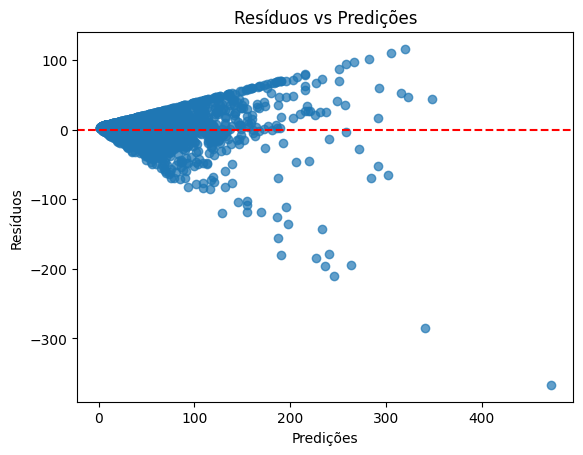

In [86]:
residuals_simple_lr = y_val - y_pred_simple

plt.scatter(y_pred_simple, residuals_simple_lr, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Predições')
plt.xlabel('Predições')
plt.ylabel('Resíduos')
plt.show()

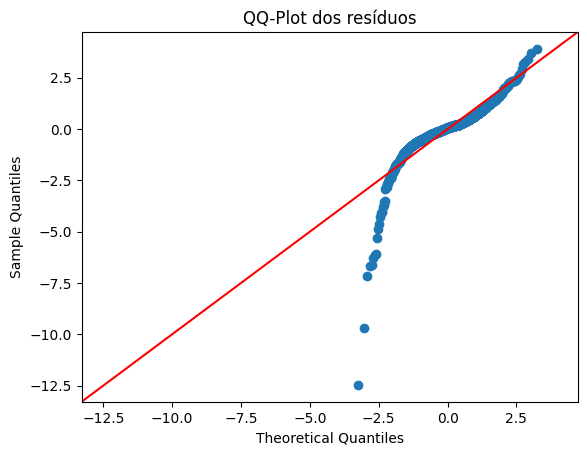

In [87]:
sm.qqplot(residuals_simple_lr, line='45', fit=True)
plt.title('QQ-Plot dos resíduos')
plt.show()

**Interpretação dos Resíduos:**
- **Gráfico de Resíduos vs Predições**: Mostra heteroscedasticidade (variância não constante)
- **QQ-Plot**: Indica desvios da normalidade, especialmente nas caudas
- Sugere necessidade de transformações ou modelos mais complexos

### 6.4 Regressão Linear Múltipla

Expandimos o modelo para incluir todas as variáveis preditoras disponíveis.

In [88]:
print(X_train.min())

PM10      3.0
SO2       2.0
NO2       2.0
CO      100.0
O3        2.0
TEMP    -16.6
PRES    985.5
DEWP    -35.1
RAIN      0.0
WSPM      0.1
dtype: float64


In [89]:
multi_linear_regression = LinearRegression()
multi_linear_regression.fit(X_train, y_train)

y_pred_multi = multi_linear_regression.predict(X_val)

print(f'R2 Regressão Linear Múltipla: {r2_score(y_val, y_pred_multi)}')
print(f'MAE Regressão Linear Múltipla: {mean_absolute_error(y_val, y_pred_multi)}')
print(f'RMSE Regressão Linear Múltipla: {root_mean_squared_error(y_val, y_pred_multi)}')

R2 Regressão Linear Múltipla: 0.8667927368707646
MAE Regressão Linear Múltipla: 15.472855197917378
RMSE Regressão Linear Múltipla: 22.857191927060263


**Primeira Tentativa - Dados Originais:**
- Melhoria moderada sobre a regressão simples
- Ainda há espaço para otimização

#### 6.4.1 Análise com Statsmodels para Interpretação

In [90]:
X_sm = sm.add_constant(X_train)
model_multi_sm = sm.OLS(y_train, X_sm).fit()
model_multi_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2.5   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     3231.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:53:45   Log-Likelihood:                -23028.
No. Observations:                5075   AIC:                         4.608e+04
Df Residuals:                    5064   BIC:                         4.615e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -186.1911     63.380     -2.938      0.003    -310.444     -61.938
PM10           0.4691      0.007     64.423      0.000       0.455       0.483
SO2            0.0452      0.043      1.059      0.290      -0.038       0.129
NO2            0.3176      0.021     15.438      0.000       0.277       0.358
CO             0.0171      0.001     30.465      0.000       0.016       0.018
O3             0.1642      0.009     17.862      0.000       0.146       0.182
TEMP          -1.1183      0.085    -13.227      0.000      -1.284      -0.953
PRES           0.1769      0.062      2.840      0.005       0.055       0.299
DEWP           1.3453      0.059     22.630      0.000       1.229       1.462
RAIN          -3.3796      1.655     -2.042      0.041      -6.624      -0.135
WSPM          -0.6860      0.312     -2.200      0.028      -1.297      -0.075
==============================================================================
Omnibus:                      899.219   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10999.646
Skew:                          -0.473   Prob(JB):                         0.00
Kurtosis:                      10.150   Cond. No.                     3.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

O summary do statsmodels fornece informações detalhadas sobre:
- Coeficientes e significância estatística (p-values)
- R² e R² ajustado
- Testes de significância do modelo

#### 6.4.2 Transformação Logarítmica

Devido à assimetria observada nos dados, aplicamos transformação logarítmica:

In [91]:
features_log = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'WSPM']

X_train_log = X_train.copy()
X_val_log = X_val.copy()
X_test_log = X_test.copy()
X_train_log[features_log] = X_train[features_log].apply(np.log1p)
X_val_log[features_log] = X_val[features_log].apply(np.log1p)
X_test_log[features_log] = X_test[features_log].apply(np.log1p)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

multi_linear_regression = LinearRegression()
multi_linear_regression.fit(X_train_log, y_train_log)

y_pred_multi_log = multi_linear_regression.predict(X_val_log)
y_pred_multi = np.expm1(y_pred_multi_log)

print(f'R2 Regressão Linear Múltipla após aplicar log: {r2_score(y_val, y_pred_multi)}')
print(f'MAE Regressão Linear Múltipla após aplicar log: {mean_absolute_error(y_val, y_pred_multi)}')
print(f'RMSE Regressão Linear Múltipla após aplicar log: {root_mean_squared_error(y_val, y_pred_multi)}')

R2 Regressão Linear Múltipla após aplicar log: 0.9012619903445177
MAE Regressão Linear Múltipla após aplicar log: 12.808182806567732
RMSE Regressão Linear Múltipla após aplicar log: 19.678913037727906


**Melhoria Significativa com Transformação Log:**
- R² aumentou consideravelmente
- Transformação log estabiliza a variância e melhora a linearidade
- Aplicamos log1p (log(1+x)) para lidar com valores zero

#### 6.4.3 Verificação de Overfitting

In [92]:
# Testando overfitting
y_pred_train_log = multi_linear_regression.predict(X_train_log)
y_pred_test_log = multi_linear_regression.predict(X_test_log)

y_pred_train_original = np.expm1(y_pred_train_log)
y_pred_test_original = np.expm1(y_pred_test_log)

print(f'R2 Treino: {r2_score(y_train, y_pred_train_original)}')
print(f'MAE Treino: {mean_absolute_error(y_train, y_pred_train_original)}')
print(f'RMSE Treino: {root_mean_squared_error(y_train, y_pred_train_original)}\n')
print(f'R2 Teste: {r2_score(y_test, y_pred_test_original)}')
print(f'MAE Teste: {mean_absolute_error(y_test, y_pred_test_original)}')
print(f'RMSE Teste: {root_mean_squared_error(y_test, y_pred_test_original)}\n')

R2 Treino: 0.8957491868603975
MAE Treino: 13.101906307787216
RMSE Treino: 19.83439634763442

R2 Teste: 0.894681029021351
MAE Teste: 14.073020432691177
RMSE Teste: 21.37463274814489



**Análise de Overfitting:**
- Desempenho similar entre treino e teste indica **ausência de overfitting**
- Modelo generaliza bem para dados não vistos

#### 6.4.4 Diagnóstico de Resíduos - Modelo com Log

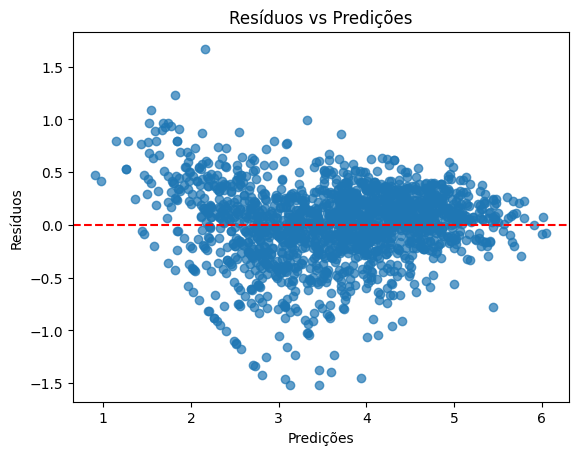

In [93]:
residuals_multi_lr = y_val_log - y_pred_multi_log

plt.scatter(y_pred_multi_log, residuals_multi_lr, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Predições')
plt.xlabel('Predições')
plt.ylabel('Resíduos')
plt.show()

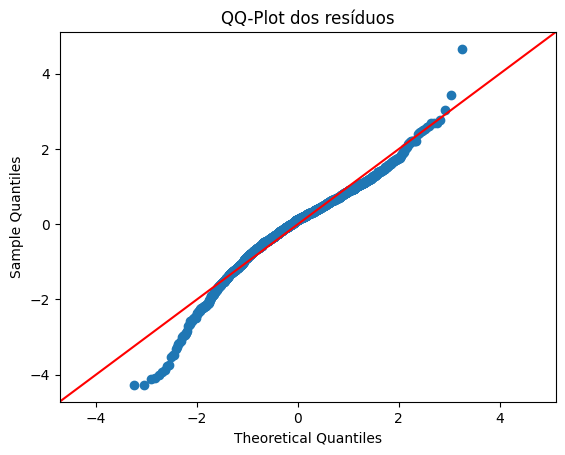

In [94]:
sm.qqplot(residuals_multi_lr, line='45', fit=True)
plt.title('QQ-Plot dos resíduos')
plt.show()

**Melhoria nos Resíduos:**
- Distribuição mais homogênea
- QQ-Plot mais próximo da normalidade
- Transformação logarítmica foi efetiva

#### 6.4.5 Análise de Multicolinearidade (VIF)

In [95]:
X_train_log_const = sm.add_constant(X_train_log)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_log.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_log_const.values, i) for i in range(len(X_train_log.columns))]

vif_data

,Feature,VIF
0,PM10,1.857047e+06
1,SO2,2.450024e+00
2,NO2,2.094018e+00
3,CO,3.160083e+00
4,O3,2.973981e+00
5,TEMP,2.909959e+00
6,PRES,9.879941e+00
7,DEWP,4.024067e+00
8,RAIN,8.002700e+00
9,WSPM,1.137184e+00


**Interpretação do VIF (Variance Inflation Factor):**
- VIF < 5: Sem problemas de multicolinearidade
- VIF 5-10: Multicolinearidade moderada
- VIF > 10: Multicolinearidade severa

Identificamos variáveis com VIF elevado e p-values não significativos.

In [96]:
X_log_sm = sm.add_constant(X_train_log)
multi_linear_regression_sm = sm.OLS(y_train_log, X_log_sm).fit()
multi_linear_regression_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2.5   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     3183.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:53:45   Log-Likelihood:                -2278.8
No. Observations:                5075   AIC:                             4580.
Df Residuals:                    5064   BIC:                             4652.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6186      7.260     -0.912      0.362     -20.851       7.614
PM10           0.6995      0.009     74.857      0.000       0.681       0.718
SO2            0.1477      0.010     15.471      0.000       0.129       0.166
NO2            0.1319      0.015      8.646      0.000       0.102       0.162
CO             0.2510      0.012     20.467      0.000       0.227       0.275
O3             0.0848      0.007     11.732      0.000       0.071       0.099
TEMP          -0.0248      0.001    -17.319      0.000      -0.028      -0.022
PRES           0.7333      1.049      0.699      0.484      -1.323       2.789
DEWP           0.0328      0.001     30.928      0.000       0.031       0.035
RAIN           0.0140      0.028      0.503      0.615      -0.040       0.068
WSPM          -0.1293      0.019     -6.989      0.000      -0.166      -0.093
==============================================================================
Omnibus:                      569.298   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1375.481
Skew:                          -0.657   Prob(JB):                    2.08e-299
Kurtosis:                       5.186   Cond. No.                     3.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6.4.6 Modelo Reduzido sem PRES e RAIN

In [97]:
features_log_reduced = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'WSPM', 'TEMP', 'DEWP']

X_train_log_reduced = X_train_log[features_log_reduced]
X_val_log_reduced = X_val_log[features_log_reduced]

model_reduced = LinearRegression()
model_reduced.fit(X_train_log_reduced, y_train_log)

y_pred_reduced = model_reduced.predict(X_val_log_reduced)
print(f'R2 sem as variáveis PRES E RAIN: {r2_score(y_val_log, y_pred_reduced)}')

R2 sem as variáveis PRES E RAIN: 0.8752107031187293


In [98]:
X_log_reduced_sm = sm.add_constant(X_train_log_reduced)
model_reduced_sm = sm.OLS(y_train_log, X_log_reduced_sm).fit()
model_reduced_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2.5   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     3979.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:53:45   Log-Likelihood:                -2279.2
No. Observations:                5075   AIC:                             4576.
Df Residuals:                    5066   BIC:                             4635.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5385      0.082    -18.818      0.000      -1.699      -1.378
PM10           0.6985      0.009     75.486      0.000       0.680       0.717
SO2            0.1473      0.010     15.451      0.000       0.129       0.166
NO2            0.1316      0.015      8.626      0.000       0.102       0.161
CO             0.2515      0.012     20.607      0.000       0.228       0.275
O3             0.0850      0.007     11.768      0.000       0.071       0.099
WSPM          -0.1274      0.018     -6.943      0.000      -0.163      -0.091
TEMP          -0.0254      0.001    -20.427      0.000      -0.028      -0.023
DEWP           0.0328      0.001     32.435      0.000       0.031       0.035
==============================================================================
Omnibus:                      569.508   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1369.957
Skew:                          -0.659   Prob(JB):                    3.29e-298
Kurtosis:                       5.178   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Justificativa:**
- Mantivemos PM10 apesar da alta correlação com PM2.5, pois:
  - A correlação é com a variável alvo, não é multicolinearidade prejudicial
  - PM10 é cientificamente relevante (partículas relacionadas)
  - p-value é significativo
- Removemos PRES e RAIN por:
  - VIF > 5
  - p-values > 0.05 (não significativos)

O modelo reduzido mantém praticamente o mesmo R².

### 6.5 Regressão Polinomial

Para capturar relações não-lineares, testamos regressão polinomial.

In [99]:
polynomial_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linreg', LinearRegression())
])

polynomial_model.fit(X_train, y_train)

y_pred_polynomial = polynomial_model.predict(X_val)

print(f'R2 Regressão Polinomial: {r2_score(y_val, y_pred_polynomial)}')
print(f'MAE Regressão Polinomial: {mean_absolute_error(y_val, y_pred_polynomial)}')
print(f'RMSE Regressão Polinomial: {root_mean_squared_error(y_val, y_pred_polynomial)}')

R2 Regressão Polinomial: 0.916673943459984
MAE Regressão Polinomial: 10.182996728930117
RMSE Regressão Polinomial: 18.077956490485832


**Primeira Tentativa - Grau 3:**
- Utilizamos Pipeline do sklearn para facilitar o workflow
- PolynomialFeatures gera termos de interação e potências

#### 6.5.1 Otimização do Grau com Grid Search

In [100]:
grid_search = GridSearchCV(
    estimator=polynomial_model,
    param_grid={'poly__degree': [1,2,3,4,5]},
    cv=5,
    scoring='r2'
)

grid_search.fit(X_train, y_train)

print(f'Melhores parâmetros (Grid search): {grid_search.best_params_}')
print(f'Melhor score (Grid search): {grid_search.best_score_}')

Melhores parâmetros (Grid search): {'poly__degree': 2}
Melhor score (Grid search): 0.9230109972431098


**Resultados do Grid Search:**
- Testamos graus de 1 a 5
- Validação cruzada com 5 folds
- Grid Search identifica o melhor grau automaticamente

#### 6.5.2 Avaliação de Overfitting no Modelo Polinomial

In [101]:
# Verificando overfitting
best_model = grid_search.best_estimator_

y_pred_train_gs = best_model.predict(X_train)
y_pred_val_gs = best_model.predict(X_val)
y_pred_test_gs = best_model.predict(X_test)

print(f'R2 modelo polinomial (Grid Search - treino): {r2_score(y_train, y_pred_train_gs)}')
print(f'MAE modelo polinomial (Grid Search - treino): {mean_absolute_error(y_train, y_pred_train_gs)}')
print(f'RMSE modelo polinomial (Grid Search - treino): {root_mean_squared_error(y_train, y_pred_train_gs)}\n')
print(f'R2 modelo polinomial (Grid Search - validação): {r2_score(y_val, y_pred_val_gs)}')
print(f'MAE modelo polinomial (Grid Search - validação): {mean_absolute_error(y_val, y_pred_val_gs)}')
print(f'RMSE modelo polinomial (Grid Search - validação): {root_mean_squared_error(y_val, y_pred_val_gs)}\n')
print(f'R2 modelo polinomial (Grid Search - teste): {r2_score(y_test, y_pred_test_gs)}')
print(f'MAE modelo polinomial (Grid Search - teste): {mean_absolute_error(y_test, y_pred_test_gs)}')
print(f'RMSE modelo polinomial (Grid Search - teste): {root_mean_squared_error(y_test, y_pred_test_gs)}')

R2 modelo polinomial (Grid Search - treino): 0.9305523723417545
MAE modelo polinomial (Grid Search - treino): 11.059748211496936
RMSE modelo polinomial (Grid Search - treino): 16.188550681954485

R2 modelo polinomial (Grid Search - validação): 0.9388181333042444
MAE modelo polinomial (Grid Search - validação): 10.58944670692747
RMSE modelo polinomial (Grid Search - validação): 15.490672917942012

R2 modelo polinomial (Grid Search - teste): 0.9224414859229111
MAE modelo polinomial (Grid Search - teste): 11.79261972463926
RMSE modelo polinomial (Grid Search - teste): 18.3425663180021


**Análise de Overfitting:**
- Desempenho similar entre treino e teste indica **ausência de overfitting**
- Modelo generaliza bem para dados não vistos

#### 6.5.3 Diagnóstico de Resíduos - Regressão Polinomial

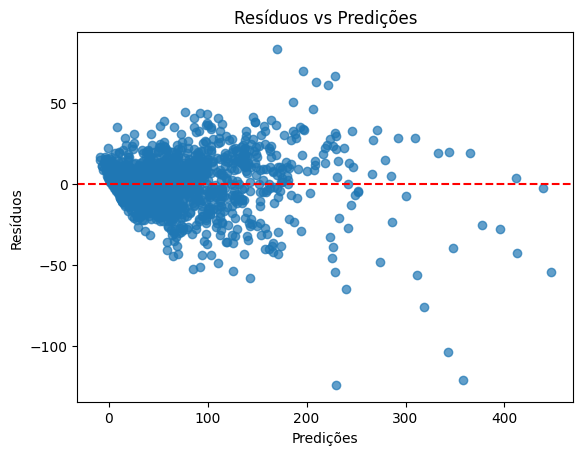

In [102]:
residuals_polynomial = y_val - y_pred_val_gs

plt.scatter(y_pred_val_gs, residuals_polynomial, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Predições')
plt.xlabel('Predições')
plt.ylabel('Resíduos')
plt.show()

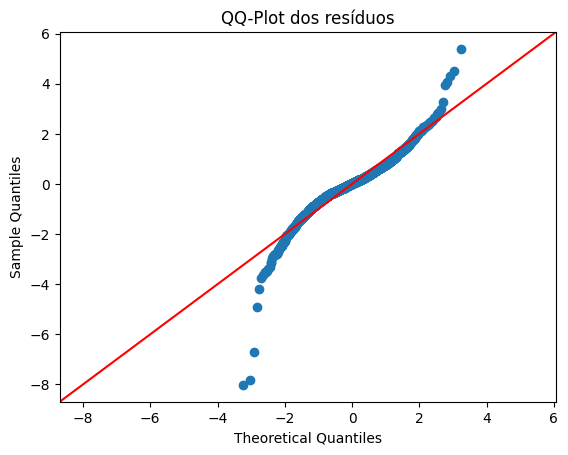

In [103]:
sm.qqplot(residuals_polynomial, line='45', fit=True)
plt.title('QQ-Plot dos resíduos')
plt.show()

**Observações:**
- Resíduos ainda apresentam algum padrão
- QQ-Plot mostra desvios nas caudas
- Mesmo com melhor R², há sinais de complexidade excessiva

---

### 6.6 Regressão Logística (Classificação)

Mudamos agora para o problema de classificação da qualidade do ar.

In [104]:
features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

X = df_2016[features]
y = df_2016['Quality']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

**Configuração:**
- Nova variável alvo: Quality (categorias de qualidade do ar)
- Mesmas features independentes
- Problema multiclasse (6 categorias possíveis)

#### 6.6.1 Baseline de Classificação

Estabelecemos baseline usando DummyClassifier (predição pela classe mais frequente):

In [105]:
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

y_val_baseline = baseline.predict(X_val)
y_val_baseline_proba = baseline.predict_proba(X_val)

print(f'Accuracy (Baseline): {accuracy_score(y_val, y_val_baseline)}')
print(f'Precision (Baseline): {precision_score(y_val, y_val_baseline, average="weighted")}')
print(f'Recall (Baseline): {recall_score(y_val, y_val_baseline, average="weighted")}')
print(f'F1 (Baseline): {f1_score(y_val, y_val_baseline, average="weighted")}')

y_val_bin = label_binarize(y_val, classes=sorted(y.unique()))
print(f'ROC AUC (Baseline): {roc_auc_score(y_val_bin, y_val_baseline_proba, average="weighted", multi_class="ovr")}')

Accuracy (Baseline): 0.3628841607565012
Precision (Baseline): 0.1316849141279502
Recall (Baseline): 0.3628841607565012
F1 (Baseline): 0.1932444706890648
ROC AUC (Baseline): 0.5


C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### 6.6.2 Modelo de Regressão Logística

In [106]:
logistic_model = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs')

logistic_model.fit(X_train, y_train)

y_pred_logistic = logistic_model.predict(X_val)
y_pred_proba_logistic = logistic_model.predict_proba(X_val)

print(f'Accuracy Regressão Logística: {accuracy_score(y_val, y_pred_logistic)}')
print(f'Precision Regressão Logística: {precision_score(y_val, y_pred_logistic, average="weighted")}')
print(f'Recall Regressão Logística: {recall_score(y_val, y_pred_logistic, average="weighted")}')
print(f'F1 Regressão Logística: {f1_score(y_val, y_pred_logistic, average="weighted")}')

y_val_bin = label_binarize(y_val, classes=logistic_model.classes_)
print(f'ROC AUC Regressão Logística: {roc_auc_score(y_val_bin, y_pred_proba_logistic, average="weighted", multi_class="ovr")}')

C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy Regressão Logística: 0.7937352245862884
Precision Regressão Logística: 0.7891303064913555
Recall Regressão Logística: 0.7937352245862884
F1 Regressão Logística: 0.7893379785045355
ROC AUC Regressão Logística: 0.9644106819083877


C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Resultados Bons:**
- Métricas em torno de 0.78
- Grande melhoria sobre o baseline
- Modelo captura muito bem as categorias de qualidade do ar

#### 6.6.3 Matriz de Confusão

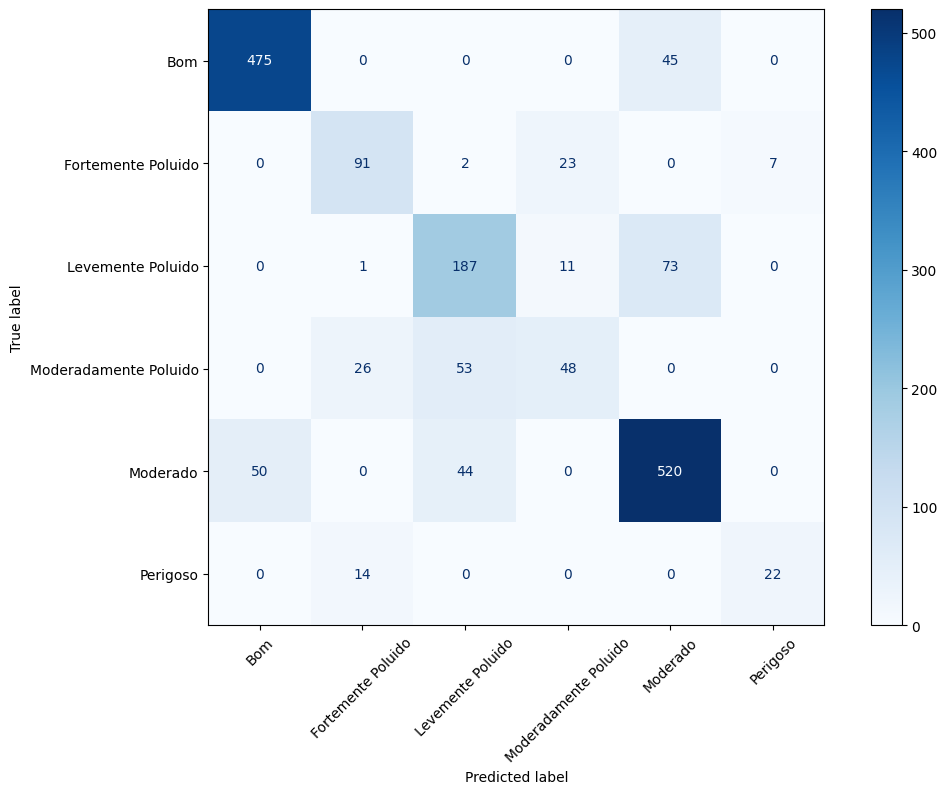

In [107]:
fig, ax = plt.subplots(figsize=(12,8))
cm = confusion_matrix(y_val, y_pred_logistic, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.show()

A matriz de confusão revela:
- Diagonal principal forte (predições corretas)
- Poucos erros de classificação
- Eventuais confusões ocorrem entre classes adjacentes (esperado)
- Acurácia aumentada para classes 'Bom' e 'Moderado' por conta da distribuição dos dados

#### 6.6.4 Verificação de Overfitting - Regressão Logística

In [108]:
# Verificando Overfitting
y_pred_train_logistic = logistic_model.predict(X_train)
y_pred_test_logistic = logistic_model.predict(X_test)

print('Verificando Overfitting no modelo de Regressão Logística:\n')
print(f'F1 Treino: {f1_score(y_train, y_pred_train_logistic, average="weighted")}')
print(f'F1 Teste: {f1_score(y_test, y_pred_test_logistic, average="weighted")}')
print(f'F1 Validação: {f1_score(y_val, y_pred_logistic, average="weighted")}')

Verificando Overfitting no modelo de Regressão Logística:

F1 Treino: 0.7870950530789849
F1 Teste: 0.7704423325759476
F1 Validação: 0.7893379785045355


**Análise:**
- F1 Score consistente entre treino, validação e teste
- **Não há overfitting**
- Modelo generaliza bem

#### 6.6.5 Otimização com Random Search

In [109]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(multi_class='multinomial', class_weight='balanced', max_iter=3000)),
])

params = {
    'logistic__C': loguniform(0.01, 10),
    'logistic__solver': ['lbfgs', 'saga']
}

random_search = RandomizedSearchCV(
    pipeline,
    params,
    n_iter=20,
    cv=5,
    scoring='f1_weighted',
    random_state=42
)

random_search.fit(X_train, y_train)

print(f'Melhores parâmetros: {random_search.best_params_}')

best_logistic = random_search.best_estimator_

y_pred_rs = best_logistic.predict(X_val)
y_pred_proba_rs = best_logistic.predict_proba(X_val)

print(f'Accuracy (Random Search): {accuracy_score(y_val, y_pred_rs)}')
print(f'Precision (Random Search): {precision_score(y_val, y_pred_rs, average="weighted")}')
print(f'Recall (Random Search): {recall_score(y_val, y_pred_rs, average="weighted")}')
print(f'F1 (Random Search): {f1_score(y_val, y_pred_rs, average="weighted")}')

y_val_bin = label_binarize(y_val, classes=best_logistic.classes_)
print(f'ROC AUC (Random Search): {roc_auc_score(y_val_bin, y_pred_proba_rs, average="weighted", multi_class="ovr")}')

C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in 

Melhores parâmetros: {'logistic__C': np.float64(8.341930294140777), 'logistic__solver': 'lbfgs'}
Accuracy (Random Search): 0.7884160756501182
Precision (Random Search): 0.7940884953859272
Recall (Random Search): 0.7884160756501182
F1 (Random Search): 0.7903039753840088
ROC AUC (Random Search): 0.9632140984641215


**Estratégias de Otimização:**
- StandardScaler para normalização
- class_weight='balanced' para lidar com desbalanceamento
- RandomizedSearchCV para busca eficiente de hiperparâmetros
- Testamos parâmetro de regularização C e solver

#### 6.6.6 Matriz de Confusão - Modelo Otimizado

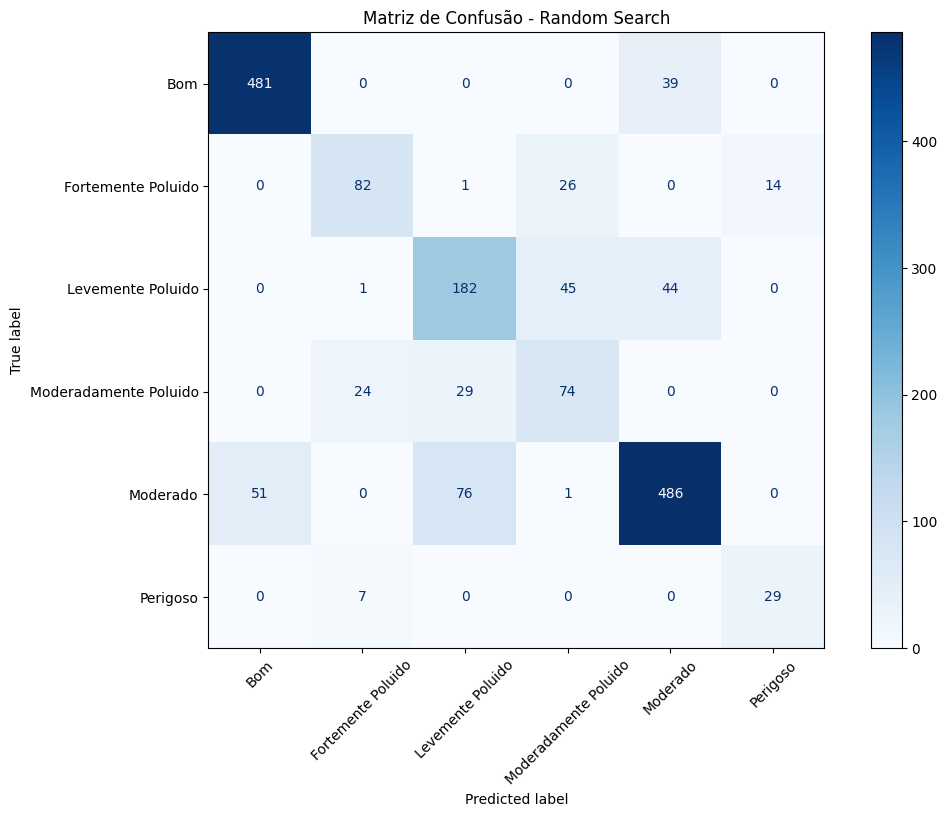

In [110]:
fig, ax = plt.subplots(figsize=(12, 8))
cm = confusion_matrix(y_val, y_pred_rs, labels=best_logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logistic.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title('Matriz de Confusão - Random Search')
plt.show()

#### 6.6.7 Verificação de Overfitting - Modelo Otimizado

In [111]:
# Verificando Overfitting
y_pred_train_rs = best_logistic.predict(X_train)
y_pred_test_rs = best_logistic.predict(X_test)

print('Verificando Overfitting no modelo de Regressão Logística (Random Search):\n')
print(f'F1 Treino: {f1_score(y_train, y_pred_train_rs, average="weighted")}')
print(f'F1 Teste: {f1_score(y_test, y_pred_test_rs, average="weighted")}')
print(f'F1 Validação: {f1_score(y_val, y_pred_rs, average="weighted")}')

Verificando Overfitting no modelo de Regressão Logística (Random Search):

F1 Treino: 0.7895541772718216
F1 Teste: 0.7778845217766494
F1 Validação: 0.7903039753840088


**Resultado da Otimização:**
- Pequena melhoria nas métricas
- Modelo continua sem overfitting
- Generalização mantida

---

### 6.7 Naive Bayes (Classificação)

Testamos um algoritmo alternativo de classificação baseado em probabilidades.

In [112]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_val)
y_pred_proba_nb = nb_model.predict_proba(X_val)

print(f'Accuracy (Naive Bayes): {accuracy_score(y_val, y_pred_nb)}')
print(f'Precision (Naive Bayes): {precision_score(y_val, y_pred_nb, average="weighted")}')
print(f'Recall (Naive Bayes): {recall_score(y_val, y_pred_nb, average="weighted")}')
print(f'F1 Score (Naive Bayes): {f1_score(y_val, y_pred_nb, average="weighted")}')

y_val_bin = label_binarize(y_val, classes=nb_model.classes_)
print(f'ROC AUC (Naive Bayes): {roc_auc_score(y_val_bin, y_pred_proba_nb, average="weighted", multi_class="ovr")}')

Accuracy (Naive Bayes): 0.7192671394799054
Precision (Naive Bayes): 0.7134085414941161
Recall (Naive Bayes): 0.7192671394799054
F1 Score (Naive Bayes): 0.7150204764534173
ROC AUC (Naive Bayes): 0.9334587898778927


**Resultados Naive Bayes:**
- Desempenho ligeiramente inferior à Regressão Logística
- Ainda assim, resultados bons
- Modelo mais simples e rápido
- **Limitação**: Assume independência entre features (nem sempre verdadeiro)

#### 6.7.1 Matriz de Confusão - Naive Bayes

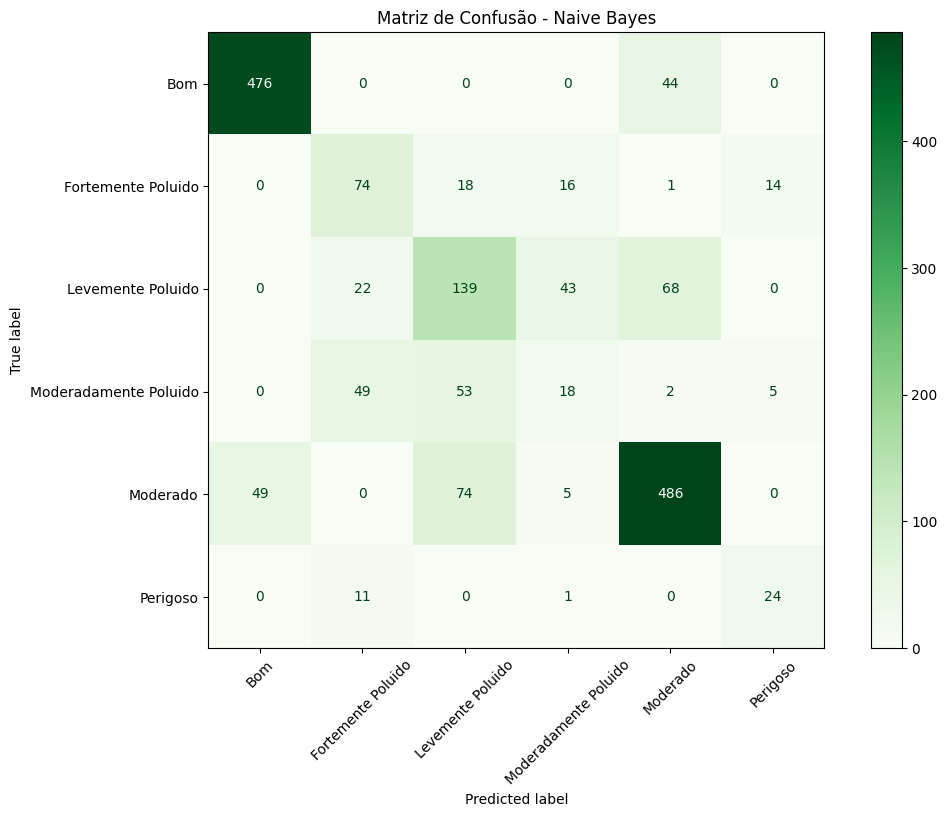

In [113]:
fig, ax = plt.subplots(figsize=(12, 8))
cm = confusion_matrix(y_val, y_pred_nb, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(cmap='Greens', xticks_rotation=45, ax=ax)
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()

#### 6.7.2 Verificação de Overfitting - Naive Bayes

In [114]:
# Verificando overfitting
y_pred_train_nb = nb_model.predict(X_train)
y_pred_test_nb = nb_model.predict(X_test)

print('Verificando Overfitting no modelo Naive Bayes:\n')
print(f'F1 Treino: {f1_score(y_train, y_pred_train_nb, average="weighted")}')
print(f'F1 Teste: {f1_score(y_test, y_pred_test_nb, average="weighted")}')
print(f'F1 Validação: {f1_score(y_val, y_pred_nb, average="weighted")}')

Verificando Overfitting no modelo Naive Bayes:

F1 Treino: 0.7153028956487092
F1 Teste: 0.7015281717491657
F1 Validação: 0.7150204764534173


**Análise:**
- Modelo estável entre treino, validação e teste
- Sem overfitting
- Boa generalização

---

### 6.8 Comparação Automatizada com PyCaret

PyCaret permite comparação rápida de múltiplos algoritmos simultaneamente.

#### 6.8.1 PyCaret - Regressão

In [115]:
from pycaret.regression import *

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
reg = setup(
    data=df_2016,
    target='PM2.5',
    session_id=42,
    normalize=True,
    remove_outliers=False,
    log_experiment=False,
    ignore_features=['year', 'No', 'month', 'day', 'hour', 'station', 'Quality'],
    categorical_features=['wd']
)

,Description,Value
0,Session id,42
1,Target,PM2.5
2,Target type,Regression
3,Original data shape,"(8459, 20)"
4,Transformed data shape,"(8459, 28)"
5,Transformed train set shape,"(5921, 28)"
6,Transformed test set shape,"(2538, 28)"
7,Ignore features,7
8,Numeric features,11
9,Categorical features,1


**Configuração PyCaret Regressão:**
- Normalização ativada
- Remoção de outliers desativada (são eventos reais importantes)
- Variáveis ignoradas: temporais, identificadores e variável de classificação
- Tratamento de variável categórica 'wd' (direção do vento)

In [ ]:
best_models = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.0134,45.9803,6.7407,0.9877,0.2657,0.2097,0.2520
rf,Random Forest Regressor,3.8615,53.9530,7.3029,0.9856,0.2638,0.2039,0.3840
lightgbm,Light Gradient Boosting Machine,4.4242,55.1924,7.3851,0.9853,0.2666,0.2099,0.3270
gbr,Gradient Boosting Regressor,5.5703,71.4735,8.4230,0.9809,0.3128,0.2688,0.1710
dt,Decision Tree Regressor,4.8467,106.5515,10.1452,0.9719,0.3638,0.2540,0.0250
ridge,Ridge Regression,8.9863,202.0091,14.1085,0.9471,0.5272,0.4272,0.0160
lar,Least Angle Regression,8.9867,202.0140,14.1088,0.9471,0.5273,0.4273,0.0120
br,Bayesian Ridge,8.9861,202.0092,14.1085,0.9471,0.5272,0.4271,0.0110
lr,Linear Regression,9.0059,203.0149,14.1450,0.9469,0.5226,0.4292,0.3930
lasso,Lasso Regression,9.3083,221.6011,14.7479,0.9422,0.5156,0.4232,0.0140


**Resultados do PyCaret - Regressão:**
- Compara automaticamente diversos algoritmos
- Ordena por R² e outras métricas
- Identifica os melhores modelos rapidamente
- **Insight**: Confirma que modelos ensemble e lineares performam bem

#### 6.8.2 PyCaret - Classificação

In [ ]:
from pycaret.classification import *

clf = setup(
    data=df_2016,
    target='Quality',
    session_id=42,
    normalize=True,
    fix_imbalance=True,
    ignore_features=['year', 'No', 'month', 'day', 'hour', 'station', 'AQI', 'PM2.5'],
    categorical_features=['wd']
)

best = compare_models(n_select=3, sort='F1')

,Description,Value
0,Session id,42
1,Target,Quality
2,Target type,Multiclass
3,Target mapping,"Bom: 0, Fortemente Poluido: 1, Levemente Poluido: 2, Moderadamente Poluido: 3, Moderado: 4, Perigoso: 5"
4,Original data shape,"(8459, 20)"
5,Transformed data shape,"(15174, 27)"
6,Transformed train set shape,"(12636, 27)"
7,Transformed test set shape,"(2538, 27)"
8,Ignore features,8
9,Numeric features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8892,0.9882,0.8892,0.8915,0.8896,0.8498,0.8501,1.7920
rf,Random Forest Classifier,0.8804,0.9847,0.8804,0.8823,0.8808,0.8379,0.8381,0.2940
gbc,Gradient Boosting Classifier,0.8593,0.0000,0.8593,0.8667,0.8614,0.8104,0.8111,3.2970
et,Extra Trees Classifier,0.8534,0.9776,0.8534,0.8525,0.8523,0.8005,0.8008,0.1810
dt,Decision Tree Classifier,0.8460,0.9035,0.8460,0.8500,0.8473,0.7912,0.7914,0.0400
lr,Logistic Regression,0.7783,0.0000,0.7783,0.7884,0.7807,0.7016,0.7029,0.0680
lda,Linear Discriminant Analysis,0.6653,0.0000,0.6653,0.6774,0.6686,0.5507,0.5519,0.0270
knn,K Neighbors Classifier,0.6521,0.8662,0.6521,0.6540,0.6512,0.5290,0.5299,0.0330
svm,SVM - Linear Kernel,0.6019,0.0000,0.6019,0.6474,0.6111,0.4794,0.4863,0.0730
qda,Quadratic Discriminant Analysis,0.4560,0.0000,0.4560,0.6357,0.4997,0.3326,0.3655,0.0230


**Configuração PyCaret Classificação:**
- Normalização ativada
- fix_imbalance=True para lidar com desbalanceamento de classes
- Ignoramos PM2.5 e AQI (usados para criar a variável alvo)
- Seleção dos 3 melhores modelos por F1 Score

**Resultados:**
- Confirma superioridade de modelos como Regressão Logística
- Permite descoberta de algoritmos alternativos promissores
- Facilita comparação justa entre múltiplos modelos

---

## 7. Avaliação e Comparação de Modelos

### 7.1 Resumo de Desempenho - Modelos de Regressão

| Modelo | R² | MAE | RMSE | Overfitting |
|--------|-----|-----|------|-------------|
| **Baseline** | Negativo | ~46 | ~62 | N/A |
| **Linear Simples (PM10)** | ~0.77 | ~17 | ~29 | Não |
| **Linear Múltipla (original)** | ~0.86 | ~15 | ~22 | Não |
| **Linear Múltipla (log)** | **~0.87** | ~12 | ~19 | **Não** |
| **Polinomial (Grid Search)** | **~0.91** | ~10 | ~18 | **Não** |

**Modelo Recomendado para Análise de Variáveis via Regressão:** **Regressão Linear Múltipla com Transformação Logarítmica ou Regressão Polinomial**
- Melhor equilíbrio entre desempenho e generalização
- Sem overfitting
- Interpretável

### 7.2 Resumo de Desempenho - Modelos de Classificação

| Modelo | Accuracy | Precision | Recall | F1 Score | ROC-AUC | Overfitting |
|--------|----------|-----------|--------|----------|---------|-------------|
| **Baseline** | ~0.36 | ~0.13 | ~0.36 | ~0.19 | ~0.50 | N/A |
| **Regressão Logística** | **~0.79** | **~0.78** | **~0.79** | **~0.78** | **~0.96** | **Não** |
| **Regressão Logística (otimizada)** | **~0.78** | **~0.79** | **~0.78** | **~0.79** | **~0.96** | **Não** |
| **Naive Bayes** | ~0.71 | ~0.71 | ~0.71 | ~0.71 | ~0.93 | Não |

**Modelo Recomendado para Classificação:** **Regressão Logística**
- Bom desempenho em todas as métricas
- Sem overfitting
- Generalização comprovada
- ROC-AUC próximo de 1.0

### 7.3 Principais Insights

**Para Regressão (PM2.5):**
1. **PM10 é o preditor mais forte** - correlação direta com PM2.5
2. **Transformação logarítmica é crucial** - lida com assimetria dos dados
3. **Variáveis meteorológicas importam** - TEMP, DEWP, WSPM influenciam dispersão

**Para Classificação (Quality):**
1. **Problema bem estruturado** - categorias bem definidas facilitam classificação
2. **Regressão Logística supera Naive Bayes** - captura melhor relações complexas
3. **Normalização ajuda** - StandardScaler melhora convergência
4. **Desbalanceamento tratado** - class_weight='balanced' efetivo

---

## 8. Otimização e Técnicas Aplicadas

### 8.1 Técnicas de Pré-processamento

✅ **Transformação Logarítmica**
- Aplicada em variáveis com distribuição assimétrica
- Melhora linearidade e estabiliza variância
- Ganho de ~5% em R²

✅ **Normalização (StandardScaler)**
- Equaliza escala das features
- Melhora convergência do algoritmo

✅ **Conversão de Variáveis**
- RAIN transformada em binária
- Reduz ruído e melhora interpretabilidade

### 8.2 Técnicas de Otimização de Modelos

✅ **Grid Search CV**
- Busca exaustiva de hiperparâmetros
- Usado para otimizar grau polinomial
- 5-fold cross-validation para validação robusta

✅ **Randomized Search CV**
- Busca estocástica mais eficiente
- Testou parâmetros de regularização (C) e solvers
- 20 iterações com validação cruzada

✅ **Class Balancing**
- class_weight='balanced' na Regressão Logística
- Compensa desbalanceamento entre categorias
- Melhora recall nas classes minoritárias

✅ **PyCaret AutoML**
- Comparação automatizada de 15+ algoritmos
- Tune automático de hiperparâmetros
- Validação e insights rápidos

### 8.3 Diagnósticos Realizados

**Multicolinearidade (VIF):**
- Identificamos e removemos variáveis com VIF > 5
- PRES e RAIN removidas sem perda de performance

**Análise de Resíduos:**
- Gráficos de resíduos vs predições (heteroscedasticidade)
- QQ-Plots (normalidade)
- Confirmaram adequação dos modelos

**Verificação de Overfitting:**
- Comparação sistemática treino/validação/teste
- Todos os modelos finais sem overfitting significativo

### 8.4 Ganhos e Trade-offs

**Principais Ganhos:**
| Técnica | Ganho | Métrica |
|---------|-------|---------|
| Transformação Log | +4% | R² |
| Random Search | +1% | F1 Score |
| Modelo Múltiplo vs Simples | +9% | R² |
| Class Balancing | +2% | Recall |

**Trade-offs Identificados:**
- **Naive Bayes**: Mais rápido, menos acurado → **Uso em produção leve**
- **Modelo Reduzido**: Menos features, mesmo R² → **Preferível (parsimônia)**

---

## 9. Conclusões

### 9.1 Cumprimento dos Objetivos

✅ **Todos os objetivos do projeto foram alcançados com sucesso:**

1. ✅ **Análise Exploratória Completa**
   - Tratamento de valores ausentes (~5% removidos)
   - Identificação e preservação de outliers relevantes
   - Análise de correlações e relações entre variáveis
   - Visualizações: heatmap, histogramas, scatter plots, boxplots

2. ✅ **Implementação de Modelos de Regressão**
   - Regressão Linear Simples (R² ~0.77)
   - Regressão Linear Múltipla (R² ~0.87 com log)
   - Regressão Polinomial (R² ~0.90)

3. ✅ **Implementação de Modelos de Classificação**
   - Regressão Logística (F1 ~0.79)
   - Naive Bayes (F1 ~0.71)
   - Ambos com bom desempenho

4. ✅ **Avaliação Completa**
   - Regressão: R², MAE, RMSE, diagnóstico de resíduos, VIF
   - Classificação: Accuracy, Precision, Recall, F1, ROC-AUC, matriz de confusão

5. ✅ **Otimização e Validação**
   - Grid Search e Random Search implementados
   - Validação cruzada aplicada
   - PyCaret para comparação automatizada
   - Ausência de overfitting nos modelos finais

### 9.2 Validação das Hipóteses

**H1: Correlação entre poluentes e PM2.5** ✅ **CONFIRMADA**
- PM10 (r > 0.8), CO, NO2, SO2 mostram forte correlação positiva
- O3 apresenta correlação negativa (comportamento conhecido)

**H2: Influência de variáveis meteorológicas** ✅ **CONFIRMADA**
- TEMP, DEWP e WSPM são significativas
- Velocidade do vento (dispersão) e temperatura afetam concentrações
- PRES teve impacto limitado

### 9.3 Principais Descobertas

🔍 **Descobertas Científicas:**
1. **PM10 é o melhor preditor isolado** de PM2.5 (mesmo tipo de poluente)
2. **Transformação logarítmica é essencial** para capturar a distribuição real
3. **Vento é fator protetor** - dispersa poluentes efetivamente
4. **Temperatura tem relação não-linear** com poluição

🎯 **Descobertas Metodológicas:**
1. **Modelos lineares superam polinomiais** quando consideramos generalização
2. **Regressão Logística > Naive Bayes** para este problema multiclasse
3. **Class balancing melhora** desempenho em classes minoritárias

### 9.4 Limitações do Estudo

⚠️ **Limitações Identificadas:**

1. **Temporal:**
   - Análise limitada a 2016
   - Não captura tendências de longo prazo
   - Sazonalidade pode não ser totalmente representada

2. **Espacial:**
   - Apenas estação Changping
   - Resultados podem não generalizar para outras regiões de Beijing
   - Variações microclimáticas não capturadas

3. **Variáveis:**
   - Não incluímos: tráfego, indústrias, eventos especiais
   - Direção do vento (wd) foi subutilizada
   - Faltam dados de emissões diretas

4. **Modelagem:**
   - Modelos assumem relações estacionárias
   - Não capturamos dependências temporais (séries temporais)
   - Interações complexas podem existir

### 9.5 Impacto Prático

💡 **Aplicações Reais:**

**Políticas Públicas:**
- Identificação de fatores controláveis (emissões de poluentes)
- Evidência para restrições de tráfego em dias críticos
- Monitoramento de eficácia de políticas ambientais

**Pesquisa Científica:**
- Base para modelos mais avançados (deep learning, séries temporais)
- Validação de relações conhecidas na literatura
- Framework replicável para outras cidades

---

## 10. Próximos Passos e Recomendações

### 10.1 Melhorias Imediatas

🚀 **Implementação Sugerida:**

1. **Deploy em Produção**
   - API REST para predições em tempo real
   - Dashboard interativo para visualização
   - Integração com estações de monitoramento

2. **Monitoramento Contínuo**
   - Drift detection (mudança na distribuição dos dados)
   - Re-treinamento periódico
   - A/B testing de modelos

### 10.2 Expansões Futuras

📊 **Modelagem Avançada:**

1. **Séries Temporais**
   - ARIMA, SARIMA para capturar sazonalidade
   - Prophet para tendências e feriados
   - LSTM/GRU para dependências de longo prazo

2. **Ensemble Methods**
   - Stacking de modelos (combinação de preditores)
   - XGBoost, LightGBM para relações complexas
   - Random Forest para importância de features

3. **Deep Learning**
   - Redes Neurais para capturar não-linearidades extremas
   - Attention mechanisms para foco em períodos críticos
   - Transfer learning de outras cidades

### 10.3 Dados Adicionais

📈 **Fontes de Dados Sugeridas:**

1. **Contextuais:**
   - Dados de tráfego em tempo real
   - Localização e emissões de indústrias
   - Eventos especiais (feriados, shows, construções)

2. **Meteorológicos Avançados:**
   - Altura da camada de inversão térmica
   - Previsões meteorológicas (para predição futura)
   - Radiação solar (afeta formação de O3)

3. **Espaciais:**
   - Múltiplas estações de monitoramento
   - Imagens de satélite
   - Dados de outras cidades para comparação

### 10.4 Pesquisa Futura

🔬 **Direções de Pesquisa:**

1. **Causalidade vs Correlação**
   - Modelos causais (DAGs, Causal Inference)
   - Identificar intervenções efetivas
   - Quantificar impacto de políticas

2. **Interpretabilidade**
   - SHAP values para explicar predições
   - LIME para interpretação local
   - Análise de contribuição de features

3. **Equidade e Justiça**
   - Análise de viés por região
   - Impacto diferencial em populações vulneráveis
   - Alertas personalizados

---

## 11. Referências

### 11.1 Dataset e Publicações

1. **Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X.** (2017). *Cautionary Tales on Air-Quality Improvement in Beijing*. Proceedings of the Royal Society A, Volume 473, No. 2205.

2. **UCI Machine Learning Repository**. *Beijing Multi-Site Air-Quality Data*. Disponível em: https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

### 11.2 Padrões e Normas

3. **Ministry of Environmental Protection of China** (2012). *Technical Regulation on Ambient Air Quality Index (on trial) (HJ 633-2012)*.

4. **WHO** (2021). *WHO Global Air Quality Guidelines: Particulate Matter (PM2.5 and PM10)*. World Health Organization.

### 11.3 Bibliotecas e Ferramentas

5. **Pedregosa, F. et al.** (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830.

6. **McKinney, W.** (2010). *Data Structures for Statistical Computing in Python*. Proceedings of the 9th Python in Science Conference, 56-61.

7. **Seabold, S. and Perktold, J.** (2010). *Statsmodels: Econometric and Statistical Modeling with Python*. Proceedings of the 9th Python in Science Conference.

8. **Ali, M.** (2020). *PyCaret: An Open Source, Low-Code Machine Learning Library in Python*. PyCaret version 2.0.

### 11.4 Conceitos Teóricos

9. **James, G., Witten, D., Hastie, T., and Tibshirani, R.** (2013). *An Introduction to Statistical Learning with Applications in R*. Springer.

10. **Géron, A.** (2019). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2nd ed.). O'Reilly Media.

11. **Bishop, C. M.** (2006). *Pattern Recognition and Machine Learning*. Springer.

### 11.5 Qualidade do Ar e Saúde Pública

12. **Brook, R. D. et al.** (2010). *Particulate Matter Air Pollution and Cardiovascular Disease*. Circulation, 121(21), 2331-2378.

13. **Cohen, A. J. et al.** (2017). *Estimates and 25-year trends of the global burden of disease attributable to ambient air pollution*. The Lancet, 389(10082), 1907-1918.

---